In [1]:
import torch
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
import sctokenizer
import spacy
import string
import re
from collections import Counter

import random
import torch
import torch.nn as nn
import torch.nn.init as weight_init
import torch.nn.functional as F
#from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.utils.data as data
from torch import optim

In [2]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1660 Ti'

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
df = pd.read_csv("E:/BITS/2nd Year/Industry project/Dataset/c_data_twocols.zip")

In [5]:
df = df.replace(r'^\s*$', np.nan, regex=True)

In [6]:
df.head()

,code,comment
0,struct _CameraFile {\n char\t\tmime_typ...,NaN
1,struct _CameraFilesystem {\n\tCameraFilesystem...,The internals of the #CameraFilesystem are onl...
2,struct _CameraWidget {\n\tCameraWidgetType typ...,CameraWidget: The internals of the #CameraWidg...
3,struct _entry {\n\tchar *name;\n\tchar *value;...,NaN
4,\tchar error[2048];\t/**< Internal kept error ...,Internal kept error message.


In [7]:
df = df.dropna(axis=0)

In [8]:
df['code'] = df['code'].astype('str')
df['comment'] = df['comment'].astype('str')

In [9]:
df_train = df.head(10000)

In [10]:
from sctokenizer import CppTokenizer

ctokenizer = CppTokenizer()

In [11]:
from spacy.lang.en.stop_words import STOP_WORDS

spacy_nlp = spacy.load('en_core_web_sm')

punctuations = string.punctuation
stop_words = spacy.lang.en.stop_words.STOP_WORDS

In [12]:
def spacy_tokenizer(sentence):
 
    #remove distracting single quotes
    sentence = re.sub('\'','',sentence)

    #remove digits adnd words containing digits
    sentence = re.sub('\w*\d\w*','',sentence)

    #replace extra spaces with single space
    sentence = re.sub(' +',' ',sentence)

    #remove unwanted lines starting from special charcters
    sentence = re.sub(r'\n: \'\'.*','',sentence)
    sentence = re.sub(r'\n!.*','',sentence)
    sentence = re.sub(r'^:\'\'.*','',sentence)
    
    #remove non-breaking new line characters
    sentence = re.sub(r'\n',' ',sentence)
    
    #remove punctunations
    sentence = re.sub(r'[^\w\s]',' ',sentence)
    
    #creating token object
    tokens = spacy_nlp(sentence)
    
    #lower, strip and lemmatize
    tokens = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in tokens]
    
    #remove stopwords, and exclude words less than 2 characters
    tokens = [word for word in tokens if word not in stop_words and word not in punctuations and len(word) > 2]
    
    #return tokens
    return tokens

In [13]:
def str_code(x):
    tokens = ctokenizer.tokenize(x)
    string_tok = [str(i.token_value)+" "+str(i.token_type) for i in tokens]
    return string_tok

In [14]:
str_code(df_train.iat[0,0])

['struct TokenType.KEYWORD',
 '_ TokenType.SPECIAL_SYMBOL',
 'CameraFilesystem TokenType.IDENTIFIER',
 '{ TokenType.SPECIAL_SYMBOL',
 'CameraFilesystemFolder TokenType.IDENTIFIER',
 '* TokenType.OPERATOR',
 'rootfolder TokenType.IDENTIFIER',
 '; TokenType.SPECIAL_SYMBOL',
 'CameraFilesystemFile TokenType.IDENTIFIER',
 '* TokenType.OPERATOR',
 'lru_first TokenType.IDENTIFIER',
 '; TokenType.SPECIAL_SYMBOL',
 'CameraFilesystemFile TokenType.IDENTIFIER',
 '* TokenType.OPERATOR',
 'lru_last TokenType.IDENTIFIER',
 '; TokenType.SPECIAL_SYMBOL',
 'unsigned TokenType.KEYWORD',
 'long TokenType.KEYWORD',
 'int TokenType.KEYWORD',
 'lru_size TokenType.IDENTIFIER',
 '; TokenType.SPECIAL_SYMBOL',
 'CameraFilesystemGetInfoFunc TokenType.IDENTIFIER',
 'get_info_func TokenType.IDENTIFIER',
 '; TokenType.SPECIAL_SYMBOL',
 'CameraFilesystemSetInfoFunc TokenType.IDENTIFIER',
 'set_info_func TokenType.IDENTIFIER',
 '; TokenType.SPECIAL_SYMBOL',
 'CameraFilesystemListFunc TokenType.IDENTIFIER',
 'file_li

In [15]:
df_train['comment_token'] = df_train['comment'].map(lambda x: spacy_tokenizer(x))
df_train['code_token'] = df_train['code'].map(lambda x: str_code(x))

In [16]:
df_train.head()

,code,comment,comment_token,code_token
1,struct _CameraFilesystem {\n\tCameraFilesystem...,The internals of the #CameraFilesystem are onl...,"[internal, camerafilesystem, visible, access, ...","[struct TokenType.KEYWORD, _ TokenType.SPECIAL..."
2,struct _CameraWidget {\n\tCameraWidgetType typ...,CameraWidget: The internals of the #CameraWidg...,"[camerawidget, internal, camerawidget, visible...","[struct TokenType.KEYWORD, _ TokenType.SPECIAL..."
4,\tchar error[2048];\t/**< Internal kept error ...,Internal kept error message.,"[internal, error, message]","[char TokenType.KEYWORD, error TokenType.KEYWO..."
5,\tstruct _GPPortInfo info;\t/**< Internal port...,Internal port information of this port.,"[internal, port, information, port]","[struct TokenType.KEYWORD, _ TokenType.SPECIAL..."
6,\tGPPortOperations *ops;\t/**< Internal port o...,Internal port operations.,"[internal, port, operation]","[GPPortOperations TokenType.IDENTIFIER, * Toke..."


In [50]:
counts_com = Counter()
for index, row in df_train.iterrows():
    counts_com.update(row['comment_token'])

In [51]:
print("num_words before:",len(counts_com.keys()))
for word in list(counts_com):
    if counts_com[word] < 2:
        del counts_com[word]
print("num_words after:",len(counts_com.keys()))

num_words before: 6881
num_words after: 3435


In [52]:
counts_code = Counter()
for index, row in df_train.iterrows():
    counts_code.update(row['code_token'])

In [53]:
print("num_words before:",len(counts_code.keys()))
for word in list(counts_code):
    if counts_code[word] < 2:
        del counts_code[word]
print("num_words after:",len(counts_code.keys()))

num_words before: 44062
num_words after: 25180


In [54]:
vocab2index_com = {"":0, "UNK":1}
words_com = ["", "UNK"]
for word in counts_com:
    vocab2index_com[word] = len(words_com)
    words_com.append(word)

In [55]:
vocab2index_code = {"":0, "UNK":1}
words_code = ["", "UNK"]
for word in counts_code:
    vocab2index_code[word] = len(words_code)
    words_code.append(word)

In [56]:
l_com = []
for index, row in df_train.iterrows():
    l_com.append(len(row['comment_token']))
print(f"Mean = {np.mean(l_com)}")
print(f"Median = {np.median(l_com)}")
print(f"Max = {np.max(l_com)}")

Mean = 10.3102
Median = 6.0
Max = 375


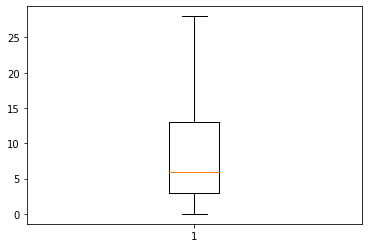

In [57]:
import matplotlib.pyplot as plt

plt.boxplot(l_com, showfliers=False)

plt.show()

In [58]:
l_code = []
for index, row in df_train.iterrows():
    l_code.append(len(row['code_token']))
print(f"Mean = {np.mean(l_code)}")
print(f"Median = {np.median(l_code)}")
print(f"Max = {np.max(l_code)}")



Mean = 156.7234
Median = 80.0
Max = 5554


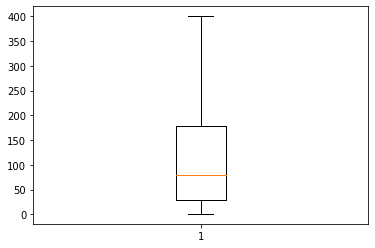

In [59]:
import matplotlib.pyplot as plt

plt.boxplot(l_code, showfliers=False)

plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


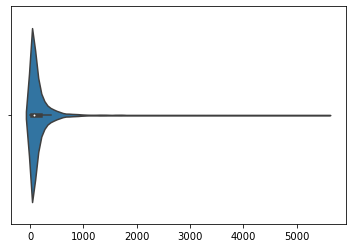

In [88]:
import seaborn as sns

ax = sns.violinplot(l_code, showextrema=False)

In [60]:
def encode_sentence(tokenized, vocab2index, N=25):
    encoded = np.zeros(N, dtype=int)
    enc1 = np.array([vocab2index.get(word, vocab2index["UNK"]) for word in tokenized])
    length = min(N, len(enc1))
    encoded[:length] = enc1[:length]
    return encoded, length

In [61]:
def encode_code(tokenized, vocab2index, N=400):
    encoded = np.zeros(N, dtype=int)
    enc1 = np.array([vocab2index.get(word, vocab2index["UNK"]) for word in tokenized])
    length = min(N, len(enc1))
    encoded[:length] = enc1[:length]
    return encoded, length

In [62]:
df_train['comment_vec'] = df_train['comment_token'].apply(lambda x: np.array(encode_sentence(x,vocab2index_com )))
df_train['code_vec'] = df_train['code_token'].apply(lambda x: np.array(encode_code(x,vocab2index_code )))

<ipython-input-62-de7353da255d>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  df_train['comment_vec'] = df_train['comment_token'].apply(lambda x: np.array(encode_sentence(x,vocab2index_com )))
<ipython-input-62-de7353da255d>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  df_train['code_vec'] = df_train['code_token'].apply(lambda x: np.array(encode_code(x,vocab2index_code )))


In [63]:
df_train.head()

,code,comment,comment_token,code_token,comment_vec,code_vec
1,struct _CameraFilesystem {\n\tCameraFilesystem...,The internals of the #CameraFilesystem are onl...,"[internal, camerafilesystem, visible, access, ...","[struct TokenType.KEYWORD, _ TokenType.SPECIAL...","[[2, 3, 4, 5, 6, 7, 8, 0, 0, 0, 0, 0, 0, 0, 0,...","[[2, 3, 4, 5, 1, 6, 7, 8, 9, 6, 1, 8, 9, 6, 1,..."
2,struct _CameraWidget {\n\tCameraWidgetType typ...,CameraWidget: The internals of the #CameraWidg...,"[camerawidget, internal, camerawidget, visible...","[struct TokenType.KEYWORD, _ TokenType.SPECIAL...","[[9, 2, 9, 4, 5, 6, 7, 8, 0, 0, 0, 0, 0, 0, 0,...","[[2, 3, 29, 5, 30, 31, 8, 32, 33, 34, 35, 36, ..."
4,\tchar error[2048];\t/**< Internal kept error ...,Internal kept error message.,"[internal, error, message]","[char TokenType.KEYWORD, error TokenType.KEYWO...","[[2, 10, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[32, 58, 34, 59, 36, 8, 41, 42, 0, 0, 0, 0, 0..."
5,\tstruct _GPPortInfo info;\t/**< Internal port...,Internal port information of this port.,"[internal, port, information, port]","[struct TokenType.KEYWORD, _ TokenType.SPECIAL...","[[2, 12, 13, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[2, 3, 60, 37, 8, 41, 42, 0, 0, 0, 0, 0, 0, 0..."
6,\tGPPortOperations *ops;\t/**< Internal port o...,Internal port operations.,"[internal, port, operation]","[GPPortOperations TokenType.IDENTIFIER, * Toke...","[[2, 12, 14, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[61, 6, 62, 8, 41, 42, 0, 0, 0, 0, 0, 0, 0, 0..."


In [64]:
code = []
comment = []
for index,row in df_train.iterrows():
    code.append((row['code_vec'])[0])
    comment.append((row['comment_vec'])[0])

In [65]:
code_len = np.array(code[0].shape)
comment_len = np.array(comment[0].shape)

In [66]:
class SeqEncoder(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_size, n_layers=1):
        super(SeqEncoder, self).__init__()
        self.emb_size = emb_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx=0)
        self.lstm = nn.LSTM(emb_size, hidden_size, batch_first=True, bidirectional=True)
        self.init_weights()
        
    def init_weights(self):
        nn.init.uniform_(self.embedding.weight, -0.1, 0.1)
        nn.init.constant_(self.embedding.weight[0], 0)
        for name, param in self.lstm.named_parameters():
            if 'weight' in name or 'bias' in name: 
                param.data.uniform_(-0.1, 0.1)

    def forward(self, inputs, input_lens=None): 
        '''
        input_lens: [batch_size]
        '''
        batch_size, seq_len=inputs.size()
        inputs = self.embedding(inputs)  # input: [batch_sz x seq_len]  embedded: [batch_sz x seq_len x emb_sz]
        inputs = F.dropout(inputs, 0.25, self.training)
        
        #if input_lens is not None:# sort and pack sequence 
        #    input_lens_sorted, indices = input_lens.sort(descending=True)
        #    inputs_sorted = inputs.index_select(0, indices)        
        #    inputs = pack_padded_sequence(inputs_sorted, input_lens_sorted.data.tolist(), batch_first=True)
            
        hids, (h_n, c_n) = self.lstm(inputs)  
        
        #if input_lens is not None: # reorder and pad
        #    _, inv_indices = indices.sort()
        #    hids, lens = pad_packed_sequence(hids, batch_first=True) # hids:[batch_size x seq_len x (n_dir*hid_sz)](biRNN)
        #    hids = F.dropout(hids, p=0.25, training=self.training)
        #    hids = hids.index_select(0, inv_indices)
        #    h_n = h_n.index_select(1, inv_indices)
        h_n = h_n.view(self.n_layers, 2, batch_size, self.hidden_size) #[n_layers x n_dirs x batch_sz x hid_sz]
        h_n = h_n[-1] 
        encoding3 = torch.cat((h_n[0], h_n[1]), dim=1)
        return encoding3 

In [67]:
class BOWEncoder(nn.Module):
  
    def __init__(self, vocab_size, emb_size, hidden_size):
        super(BOWEncoder, self).__init__()
        self.emb_size=emb_size
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, emb_size)
        
        self.init_weights()
        
    def init_weights(self):
        nn.init.uniform_(self.embedding.weight, -0.1, 0.1)
        nn.init.constant_(self.embedding.weight[0], 0)
        
    def forward(self, input, input_len=None): 
        batch_size, seq_len =input.size()
        embedded = self.embedding(input)  
        embedded= F.dropout(embedded, 0.25, self.training) 
        maxpooling = nn.MaxPool1d(kernel_size = seq_len, stride=seq_len)
        output_pool = maxpooling(embedded.transpose(1,2)).squeeze(2) 
        encoding = output_pool
        return encoding

In [77]:
class JointEmbedder(nn.Module):

    def __init__(self):
        super(JointEmbedder, self).__init__()
        self.margin = 0.04
               
        
        self.code_encoder=BOWEncoder(10000,512,512)
        self.comment_encoder=SeqEncoder(10000,512,1024)

        
        self.w_code = nn.Linear(512, 512)
        self.w_comment = nn.Linear(2*1024, 512)
        
        self.init_weights()
        
    def init_weights(self):# Initialize Linear Weight 
        for m in [self.w_code]:        
            m.weight.data.uniform_(-0.1, 0.1)#nn.init.xavier_normal_(m.weight)
            nn.init.constant_(m.bias, 0.) 
            
    def code_encoding(self, code_tokens, code_len):
        code_repr=self.code_encoder(code_tokens, code_len)
        code_repr = self.w_code(code_repr)
        return code_repr
        
    def comment_encoding(self, comment, comment_len):
        comment_repr=self.comment_encoder(comment, comment_len)
        comment_repr=self.w_comment(comment_repr)
        return comment_repr
    
    def similarity(self, code_vec, comment_vec):
   
            return F.cosine_similarity(code_vec, comment_vec)
      
    
    def forward(self, code, code_len, comment_anchor, comment_anchor_len, comment_neg, comment_neg_len):
        batch_size=code.size(0)
        code_repr=self.code_encoding(code, code_len)
        comment_anchor_repr=self.comment_encoding(comment_anchor, comment_anchor_len)
        comment_neg_repr=self.comment_encoding(comment_neg, comment_neg_len)
    
        anchor_sim = self.similarity(code_repr, comment_anchor_repr)
        neg_sim = self.similarity(code_repr, comment_neg_repr) # [batch_sz x 1]
        
        #loss=(self.margin-anchor_sim+neg_sim).clamp(min=1e-6).mean()
        loss=(self.margin-anchor_sim+neg_sim).mean()
        
        return loss

In [78]:
model = JointEmbedder()

In [79]:
testcode = torch.from_numpy(np.array(code[0:2]))
testcomm = torch.from_numpy(np.array(comment[0:2]))
testnegcomm = torch.from_numpy(np.array(comment[4:6]))

In [80]:
model(testcode,code_len,testcomm,comment_len,testnegcomm,comment_len)

tensor(0.0425, grad_fn=<MeanBackward0>)

In [81]:
def train(data_loader):
    #optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)        
    #scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps,num_training_steps=len(data_loader)*epochs)
    optimizer = torch.optim.Adam(model.parameters())
    n_iters = len(data_loader)
  
    for epoch in range(10): 
       
        losses=[]
        for batch in data_loader:

            model.train()
            #batch_gpu = [tensor.to(device) for tensor in batch]
            #loss = model(*batch_gpu)
            loss = model(*batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            #scheduler.step()
            model.zero_grad()
            losses.append(loss.item())
            print(loss.item())

In [82]:
class CodeSearchDataset(data.Dataset):
    def __init__(self, code, code_len, comment=None, comment_len=None):
        
        self.code = code
        self.code_len = code_len
        self.data_len = len(code)
        self.comment = comment
        self.comment_len = comment_len
        
    def __getitem__(self, idx):
        
        cd = torch.from_numpy(self.code[idx])
        cd = cd.unsqueeze(dim=0)
        cd_len = torch.from_numpy(self.code_len)
        
        #if self.training:
        good_desc = torch.from_numpy(self.comment[idx])
        good_desc = good_desc.unsqueeze(dim=0)
        good_desc_len = torch.from_numpy(self.comment_len)
            
        rand_idx=random.randint(0, self.data_len-1)
            
        bad_desc = torch.from_numpy(self.comment[rand_idx])
        bad_desc = bad_desc.unsqueeze(dim=0)
        bad_desc_len = torch.from_numpy(self.comment_len)
            
        return cd, cd_len, good_desc, good_desc_len, bad_desc, bad_desc_len
        #return cd, code_len
    
    def __len__(self):
        return(self.data_len)

In [83]:
test = CodeSearchDataset(code, code_len, comment, comment_len)

In [84]:
for i in test:
    print(type(i[1]))
    break

<class 'torch.Tensor'>


In [85]:
train(test)

0.02703312784433365
-0.21143141388893127
0.03513491153717041
0.03711444139480591
0.03110271692276001
0.027284443378448486
-0.02784562110900879
0.005425155162811279
-0.1734704077243805
-0.039711833000183105
-1.015894889831543
-1.2918078899383545
-0.870229959487915
0.28301072120666504
-1.7397842407226562


KeyboardInterrupt: 